In [1]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Dense , Input , Dropout , BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from utils import *

2025-05-03 14:36:40.824557: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-03 14:36:42.800255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746279403.469169   46142 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746279403.653518   46142 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746279405.301157   46142 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
IMG_SIZE = (100,100)
early_stopping = EarlyStopping(monitor='accuracy', patience=20)

In [4]:
def model_cnn(size:tuple[int,int]) -> Sequential:
    model = Sequential()
    model.add(Input((size[0], size[1], 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(96, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(96, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    return model

In [5]:
model_cnn1 = MModel("model_cnn1")
model_cnn1.set_model(model_cnn(IMG_SIZE))
model_cnn1.summary()

I0000 00:00:1746279443.531925   46142 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13499 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 100, 100, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 98, 98, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 96)       │       110,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 64)       │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,514 (1.29 MB)

 Trainable params: 338,508 (1.29 MB)

 Non-trainable params: 6 (24.00 B)

In [6]:
model_cnn1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
history = model_cnn1.fit(epochs=200, verbose=1, callbacks=[early_stopping])

(100, 100)
Found 2274 images belonging to 6 classes.
Found 253 images belonging to 6 classes.


I0000 00:00:1746279447.049624   46423 service.cc:152] XLA service 0x7f7b60014ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746279447.049653   46423 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-05-03 14:37:27.179359: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746279447.388429   46423 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step

I0000 00:00:1746279450.249443   46423 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

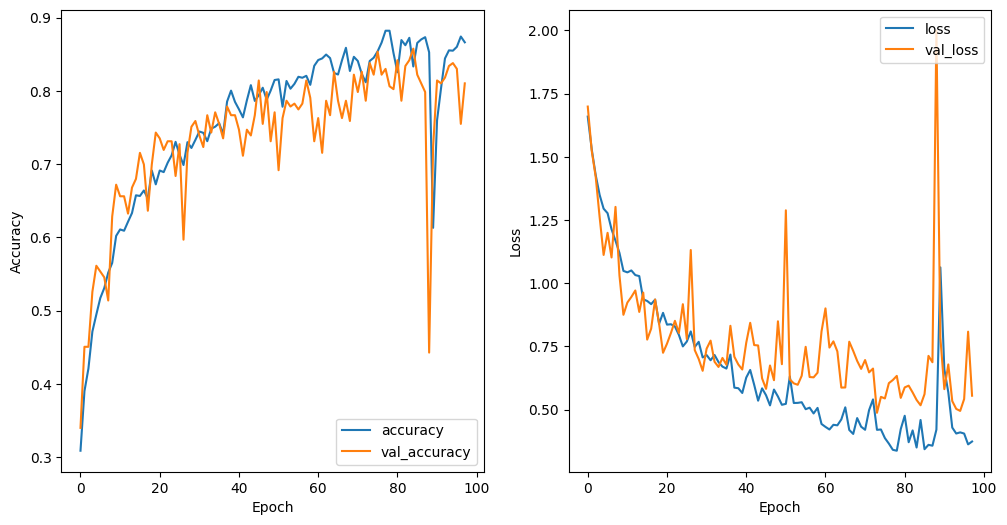

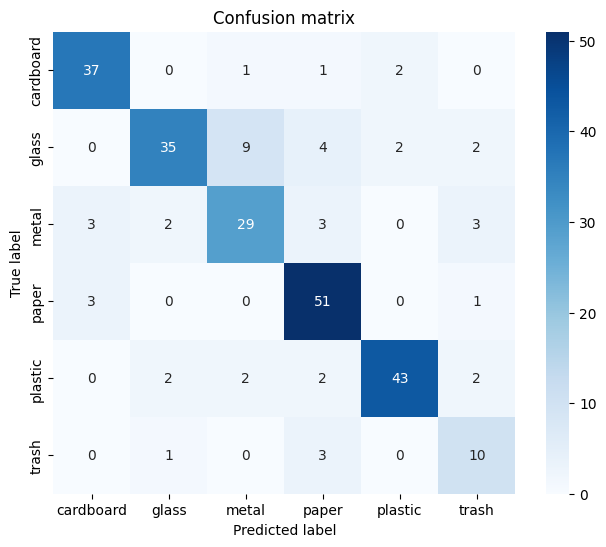

In [8]:
model_cnn1.evaluate()

In [9]:
IMG_SIZE = (128,96)
model_cnn2 = MModel("model_cnn2")
model_cnn2.set_model(model_cnn(IMG_SIZE))
model_cnn2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 128, 96, 3)     │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 126, 94, 64)    │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 63, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 61, 45, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 22, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 20, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 8, 96)      │       110,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 2, 64)       │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342,610 (1.31 MB)

 Trainable params: 342,604 (1.31 MB)

 Non-trainable params: 6 (24.00 B)

In [10]:
model_cnn2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_cnn2.fit(epochs=300, verbose=1, callbacks=[early_stopping])

(128, 96)
Found 2274 images belonging to 6 classes.
Found 253 images belonging to 6 classes.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

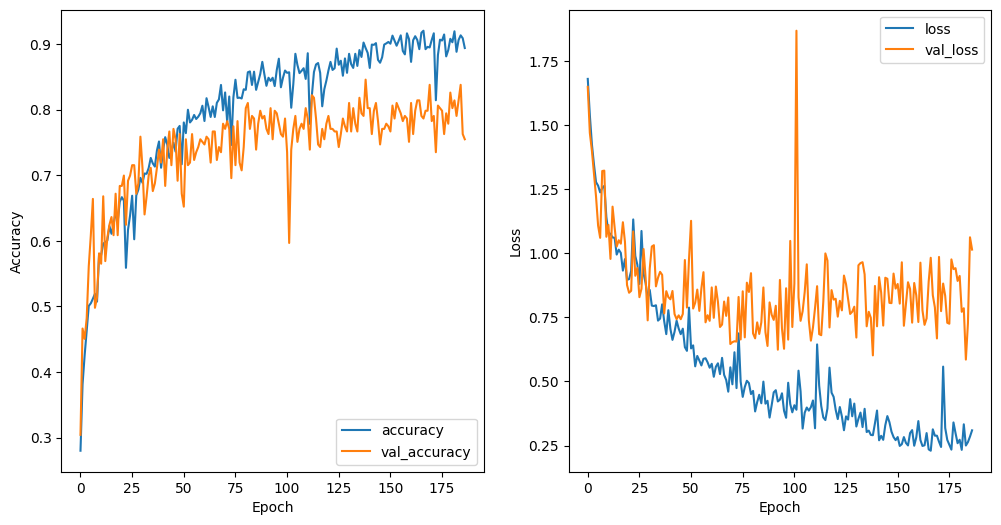

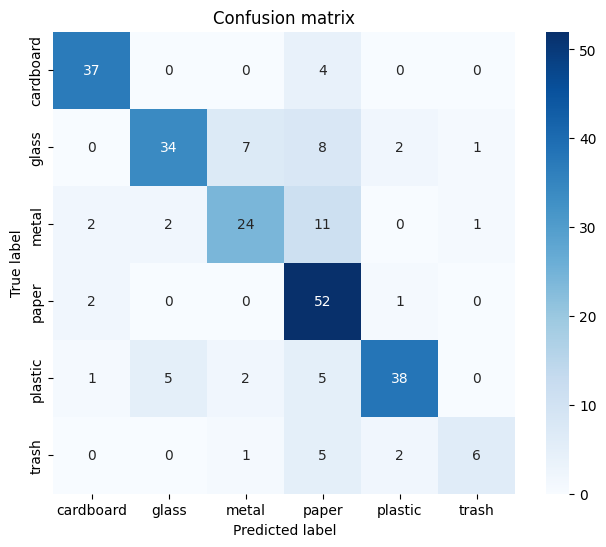

In [11]:
model_cnn2.evaluate()

In [12]:
IMG_SIZE = (512,384)
model_cnn3 = MModel("model_cnn3_full")
model_cnn3.set_model(model_cnn(IMG_SIZE))
model_cnn3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_2           │ (None, 512, 384, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 510, 382, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 255, 191, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 253, 189, 96)   │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 126, 94, 96)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 124, 92, 128)   │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 62, 46, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 60, 44, 96)     │       110,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 22, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 20, 64)     │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       573,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 907,858 (3.46 MB)

 Trainable params: 907,852 (3.46 MB)

 Non-trainable params: 6 (24.00 B)

In [13]:
model_cnn3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_cnn3.fit(epochs=300, verbose=1, callbacks=[early_stopping])

(512, 384)
Found 2274 images belonging to 6 classes.
Found 253 images belonging to 6 classes.


7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

2025-05-03 14:38:21.380961: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv-bias-activation.16 = (f32[29,96,253,189]{3,2,1,0}, u8[0]{0}) custom-call(f32[29,64,255,191]{3,2,1,0} %bitcast.349, f32[96,64,3,3]{3,2,1,0} %bitcast.356, f32[96]{0} %bitcast.358), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_2_1/conv2d_11_1/convolution" source_file="/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-05-03 14:38:03.474343: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 269.037506m

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ -18s -17872902us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/st

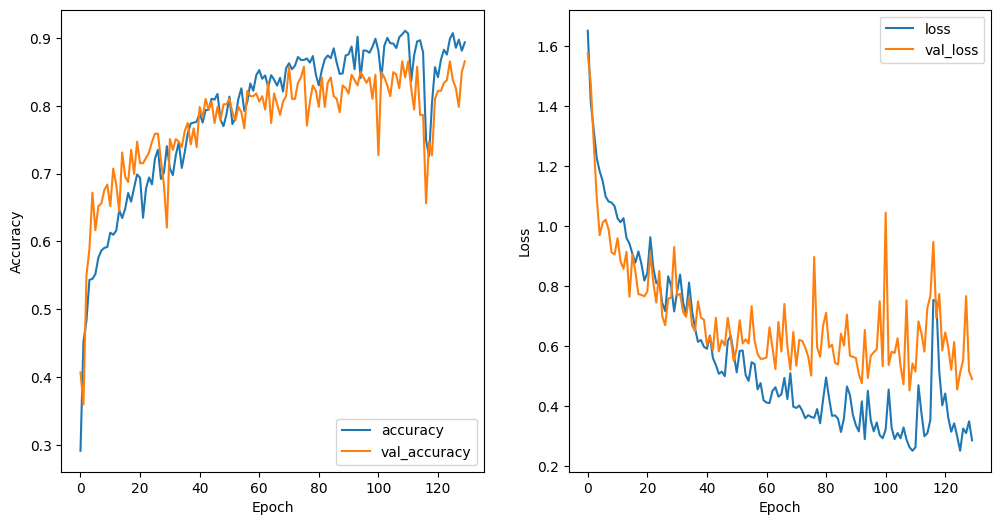

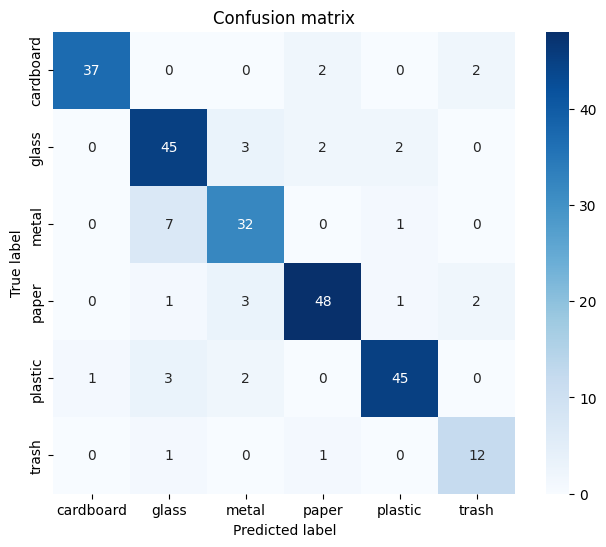

In [14]:
model_cnn3.evaluate()

In [15]:
IMG_SIZE = (256,192)
model_cnn4 = MModel("model_cnn4")
model_cnn4.set_model(model_cnn(IMG_SIZE))
model_cnn4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_3           │ (None, 256, 192, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 254, 190, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 127, 95, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 125, 93, 96)    │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 62, 46, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 60, 44, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 30, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 28, 20, 96)     │       110,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 14, 10, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 12, 8, 64)      │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 6, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        98,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 432,722 (1.65 MB)

 Trainable params: 432,716 (1.65 MB)

 Non-trainable params: 6 (24.00 B)

In [16]:
model_cnn4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_cnn4.fit(epochs=300, verbose=1, callbacks=[early_stopping])

(256, 192)
Found 2274 images belonging to 6 classes.
Found 253 images belonging to 6 classes.


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

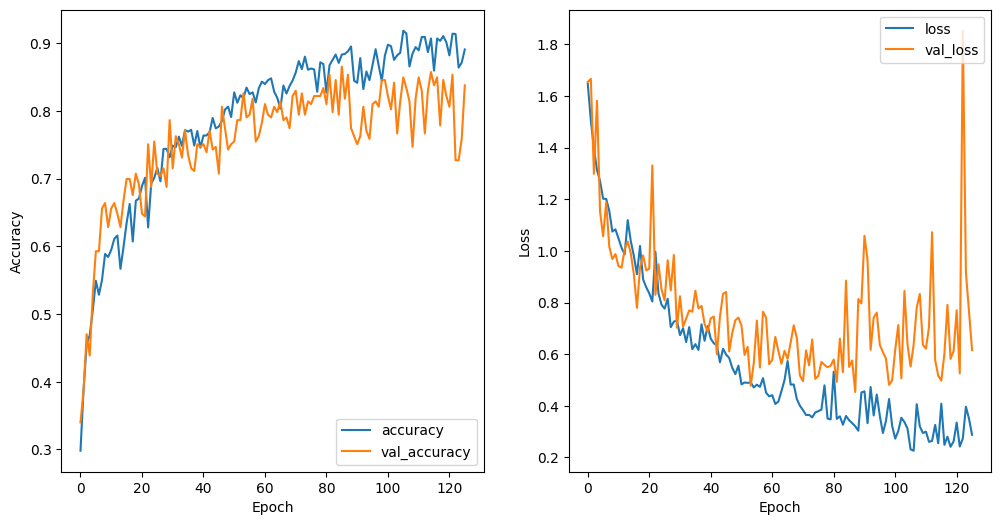

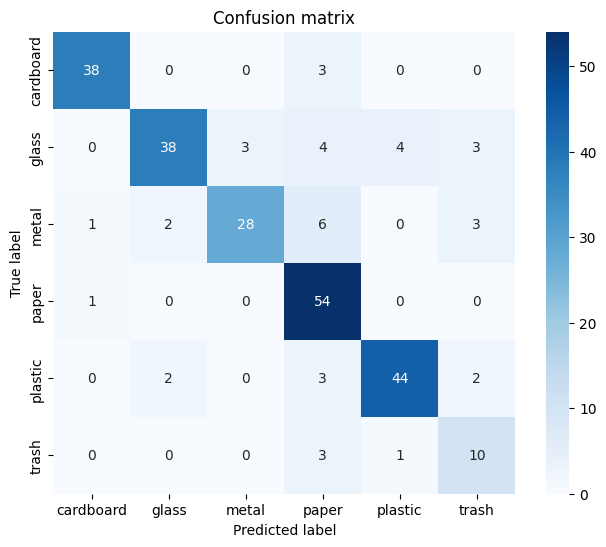

In [17]:
model_cnn4.evaluate()

In [18]:
def model_cnn_b(size:tuple[int,int], dropout:float=0.25) -> Sequential:
    
    def block(model, filters, kernel_size, pool_size, dropout):
        model.add(BatchNormalization())
        model.add(Conv2D(filters, kernel_size, activation='relu'))
        model.add(Dropout(dropout))
        model.add(MaxPooling2D(pool_size))
    
    model = Sequential()
    model.add(Input((size[0], size[1], 3)))
    block(model, 64, (3,3), (2,2), dropout)
    block(model, 64, (3,3), (2,2), dropout)
    block(model, 128, (3,3), (2,2), dropout)
    block(model, 128, (3,3), (2,2), dropout)
    block(model, 256, (3,3), (2,2), dropout)
    block(model, 256, (3,3), (2,2), dropout)
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.1)))
    model.add(Dense(6, activation='softmax'))
    return model

In [19]:
IMG_SIZE = (512,384)
model_cnn5 = MModel("model_cnn5")
model_cnn5.set_model(model_cnn_b(IMG_SIZE,dropout=0.3))
model_cnn5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_4           │ (None, 512, 384, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 510, 382, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 510, 382, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 255, 191, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 255, 191, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 253, 189, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 253, 189, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 126, 94, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 126, 94, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 124, 92, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 124, 92, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 62, 46, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 62, 46, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 60, 44, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 44, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 30, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 30, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 28, 20, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 28, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 14, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 12, 8, 256)     │       590,08

 Total params: 1,935,314 (7.38 MB)

 Trainable params: 1,934,028 (7.38 MB)

 Non-trainable params: 1,286 (5.02 KB)

In [20]:
model_cnn5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_cnn5.fit(epochs=300, verbose=1, callbacks=[early_stopping])

(512, 384)
Found 2274 images belonging to 6 classes.
Found 253 images belonging to 6 classes.


/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300


2025-05-03 14:39:22.517456: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4082', 4 bytes spill stores, 4 bytes spill loads

2025-05-03 14:39:41.500445: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng14{} for conv %cudnn-conv-bias-activation.18 = (f32[32,64,510,382]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,512,384]{3,2,1,0} %bitcast.22895, f32[64,3,3,3]{3,2,1,0} %bitcast.22886, f32[64]{0} %bitcast.22945), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_4_1/conv2d_20_1/convolution" source_file="/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.2823 - loss: 21.6865

2025-05-03 14:40:21.440111: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_258', 4 bytes spill stores, 4 bytes spill loads



72/72 ━━━━━━━━━━━━━━━━━━━━ 64s 689ms/step - accuracy: 0.2828 - loss: 21.5845 - val_accuracy: 0.1700 - val_loss: 6.4398
Epoch 2/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 579ms/step - accuracy: 0.4178 - loss: 4.6109 - val_accuracy: 0.2095 - val_loss: 3.0924
Epoch 3/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 580ms/step - accuracy: 0.4377 - loss: 2.2238 - val_accuracy: 0.2055 - val_loss: 2.3159
Epoch 4/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 585ms/step - accuracy: 0.4506 - loss: 1.8157 - val_accuracy: 0.2253 - val_loss: 2.0258
Epoch 5/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 578ms/step - accuracy: 0.4634 - loss: 1.6365 - val_accuracy: 0.2885 - val_loss: 1.9461
Epoch 6/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 577ms/step - accuracy: 0.4888 - loss: 1.4877 - val_accuracy: 0.2213 - val_loss: 2.0371
Epoch 7/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 580ms/step - accuracy: 0.5215 - loss: 1.4170 - val_accuracy: 0.2490 - val_loss: 1.8717
Epoch 8/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 579ms/step - accuracy: 0.5732 - loss: 1.3127 - val_accurac

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step


/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1

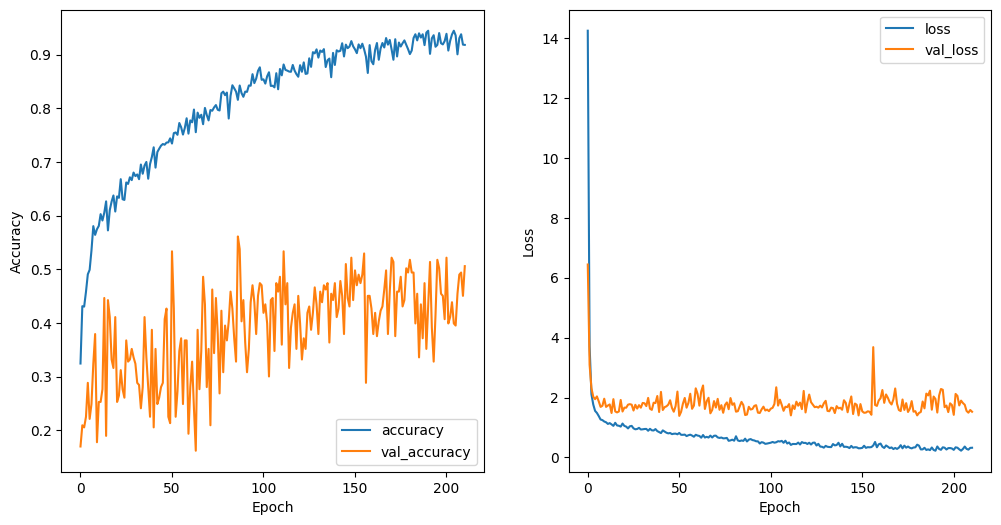

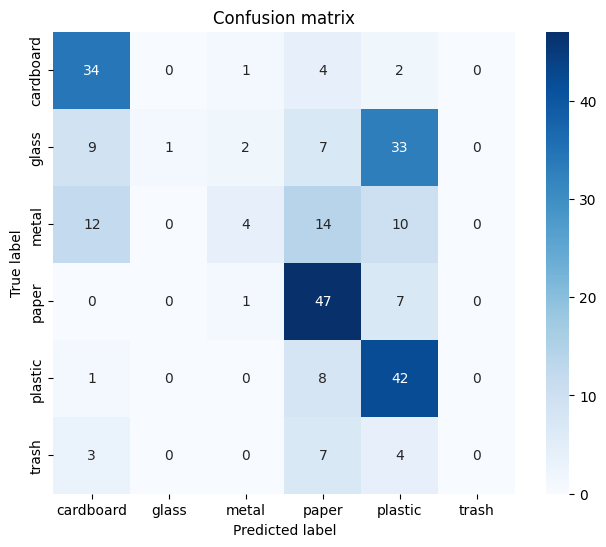

In [21]:
model_cnn5.evaluate()

In [22]:
IMG_SIZE = (512,384)
model_cnn6 = MModel("model_cnn6")
model_cnn6.set_model(model_cnn_b(IMG_SIZE, dropout=0.5))
model_cnn6.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_10          │ (None, 512, 384, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 510, 382, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 510, 382, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 255, 191, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 255, 191, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 253, 189, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 253, 189, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 126, 94, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 126, 94, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 124, 92, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 124, 92, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 62, 46, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 62, 46, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 60, 44, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 60, 44, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 30, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 30, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 28, 20, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 28, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 14, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 14, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 12, 8, 256)     │       590,08

 Total params: 1,935,314 (7.38 MB)

 Trainable params: 1,934,028 (7.38 MB)

 Non-trainable params: 1,286 (5.02 KB)

In [23]:
model_cnn6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_cnn6.fit(epochs=300, verbose=1, callbacks=[early_stopping])

(512, 384)
Found 2274 images belonging to 6 classes.
Found 253 images belonging to 6 classes.


/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 636ms/step - accuracy: 0.2933 - loss: 22.8853 - val_accuracy: 0.2174 - val_loss: 7.2062
Epoch 2/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 577ms/step - accuracy: 0.4328 - loss: 5.5154 - val_accuracy: 0.2174 - val_loss: 3.3277
Epoch 3/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 574ms/step - accuracy: 0.4409 - loss: 2.7199 - val_accuracy: 0.2174 - val_loss: 2.3902
Epoch 4/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 574ms/step - accuracy: 0.4722 - loss: 1.8882 - val_accuracy: 0.2174 - val_loss: 2.2276
Epoch 5/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 572ms/step - accuracy: 0.4736 - loss: 1.7652 - val_accuracy: 0.2174 - val_loss: 2.1643
Epoch 6/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 570ms/step - accuracy: 0.5131 - loss: 1.6021 - val_accuracy: 0.2292 - val_loss: 2.0728
Epoch 7/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 579ms/step - accuracy: 0.5271 - loss: 1.4965 - val_accuracy: 0.2806 - val_loss: 2.0695
Epoch 8/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 569ms/step - accuracy: 0.4939 - loss: 1.4976 -

IOStream.flush timed out


72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 575ms/step - accuracy: 0.9484 - loss: 0.3766 - val_accuracy: 0.2806 - val_loss: 3.6495
Epoch 247/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 578ms/step - accuracy: 0.9435 - loss: 0.3454 - val_accuracy: 0.2292 - val_loss: 4.0354
Epoch 248/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 579ms/step - accuracy: 0.9335 - loss: 0.3786 - val_accuracy: 0.2213 - val_loss: 3.7207
Epoch 249/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 576ms/step - accuracy: 0.9410 - loss: 0.3456 - val_accuracy: 0.2174 - val_loss: 5.2482
Epoch 250/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 576ms/step - accuracy: 0.9387 - loss: 0.3181 - val_accuracy: 0.2332 - val_loss: 4.4665
Epoch 251/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 591ms/step - accuracy: 0.9079 - loss: 0.4084 - val_accuracy: 0.2174 - val_loss: 5.8041
Epoch 252/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 571ms/step - accuracy: 0.9184 - loss: 0.3742 - val_accuracy: 0.3004 - val_loss: 3.7882
Epoch 253/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 566ms/step - accuracy: 0.9300 - loss: 0.3058 

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━

/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

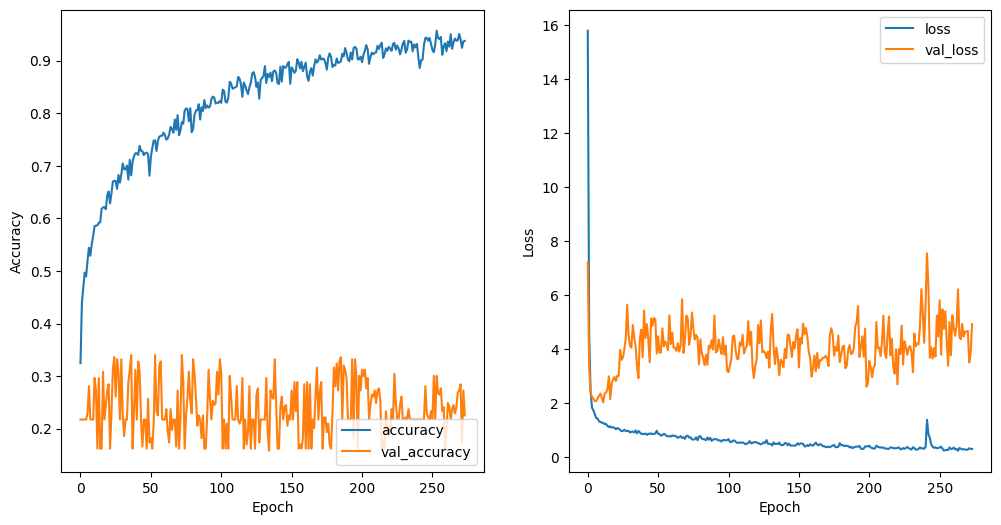

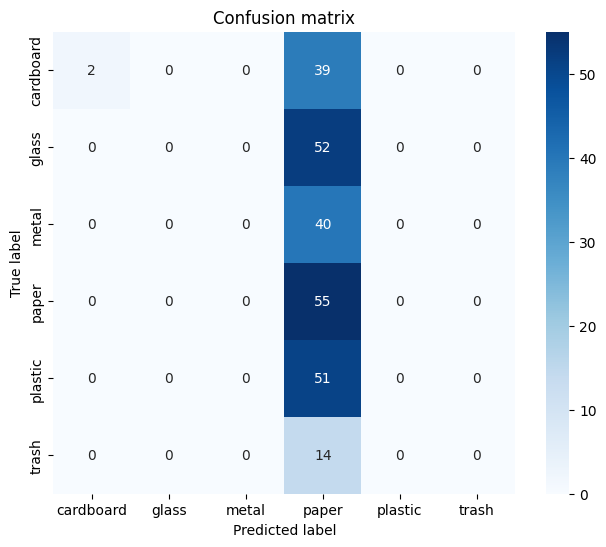

In [24]:
model_cnn6.evaluate()

In [25]:
IMG_SIZE = (192,192)
model_cnn7 = MModel("model_cnn7")
model_cnn7.set_model(model_cnn_b(IMG_SIZE, dropout=0.3))
model_cnn7.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_16          │ (None, 192, 192, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 190, 190, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 190, 190, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 95, 95, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 95, 95, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 93, 93, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 93, 93, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 44, 44, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 44, 44, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 20, 20, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 2, 2, 256)      │       590,08

 Total params: 1,181,650 (4.51 MB)

 Trainable params: 1,180,364 (4.50 MB)

 Non-trainable params: 1,286 (5.02 KB)

In [26]:
model_cnn7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_cnn7.fit(epochs=300, verbose=1, callbacks=[early_stopping])

(192, 192)
Found 2274 images belonging to 6 classes.
Found 253 images belonging to 6 classes.


/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
17/72 ━━━━━━━━━━━━━━━━━━━━ 1:12 1s/step - accuracy: 0.3137 - loss: 18.5827  

2025-05-03 20:19:13.659912: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng11{k2=0,k3=0} for conv %cudnn-conv-bias-activation.15 = (f32[32,64,190,190]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,192,192]{3,2,1,0} %bitcast.938, f32[64,3,3,3]{3,2,1,0} %bitcast.945, f32[64]{0} %bitcast.947), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_6_1/conv2d_32_1/convolution" source_file="/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-05-03 20:19:13.666266: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 18.

72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 278ms/step - accuracy: 0.3739 - loss: 15.5795 - val_accuracy: 0.2095 - val_loss: 7.7340
Epoch 2/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - accuracy: 0.5049 - loss: 6.0298 - val_accuracy: 0.1621 - val_loss: 4.0286
Epoch 3/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 181ms/step - accuracy: 0.4945 - loss: 3.0113 - val_accuracy: 0.1700 - val_loss: 2.7710
Epoch 4/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - accuracy: 0.5704 - loss: 1.8465 - val_accuracy: 0.2609 - val_loss: 2.2371
Epoch 5/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step - accuracy: 0.5645 - loss: 1.4917 - val_accuracy: 0.2609 - val_loss: 2.0177
Epoch 6/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - accuracy: 0.5936 - loss: 1.3373 - val_accuracy: 0.2925 - val_loss: 1.7873
Epoch 7/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step - accuracy: 0.6125 - loss: 1.1688 - val_accuracy: 0.3992 - val_loss: 1.7632
Epoch 8/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step - accuracy: 0.6234 - loss: 1.1773 - val_accurac

IOStream.flush timed out


72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - accuracy: 0.9162 - loss: 0.2846 - val_accuracy: 0.4704 - val_loss: 1.6675
Epoch 109/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - accuracy: 0.8966 - loss: 0.3431 - val_accuracy: 0.2846 - val_loss: 1.8899
Epoch 110/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 184ms/step - accuracy: 0.8604 - loss: 0.4629 - val_accuracy: 0.4308 - val_loss: 1.5354
Epoch 111/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - accuracy: 0.9135 - loss: 0.3114 - val_accuracy: 0.4348 - val_loss: 1.7631
Epoch 112/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.8667 - loss: 0.4651 - val_accuracy: 0.3794 - val_loss: 1.8433
Epoch 113/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step - accuracy: 0.8926 - loss: 0.3619 - val_accuracy: 0.4822 - val_loss: 1.4790
Epoch 114/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - accuracy: 0.8982 - loss: 0.3340 - val_accuracy: 0.5296 - val_loss: 1.3981
Epoch 115/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step - accuracy: 0.8824 - loss: 0.3996 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ -19s -1850

/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

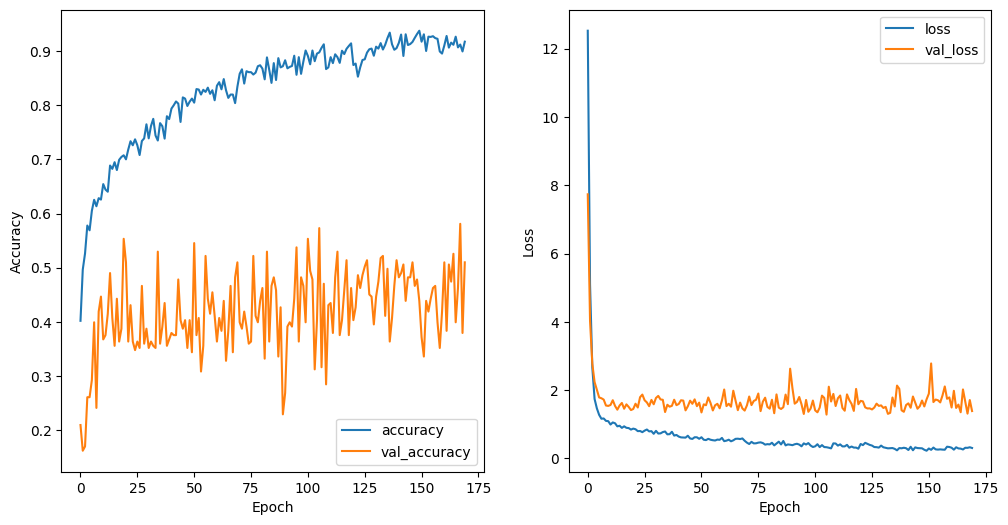

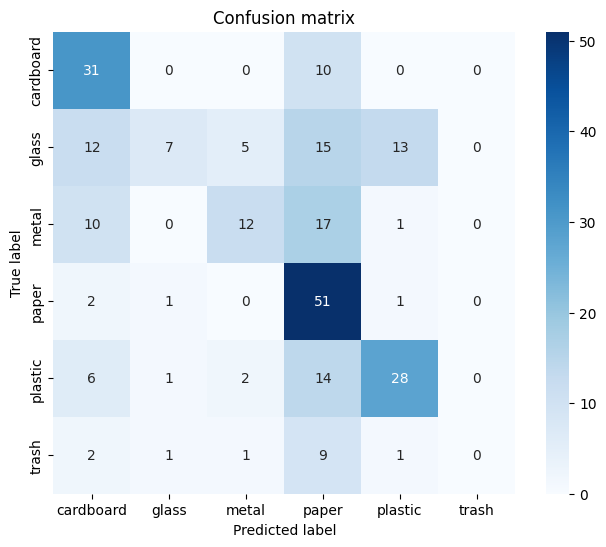

In [27]:
model_cnn7.evaluate()

In [28]:
def model_cnn_c(size:tuple[int,int], dropout:float=0.25) -> Sequential:
    
    def block(model, filters, kernel_size, pool_size, dropout):
        model.add(BatchNormalization())
        model.add(Conv2D(filters, kernel_size, activation='relu'))
        model.add(Dropout(dropout))
        model.add(MaxPooling2D(pool_size))
    
    model = Sequential()
    model.add(Input((size[0], size[1], 3)))
    block(model, 64, (3,3), (2,2), dropout)
    block(model, 128, (3,3), (2,2), dropout)
    block(model, 128, (3,3), (2,2), dropout)
    block(model, 256, (3,3), (2,2), dropout)
    block(model, 256, (3,3), (2,2), dropout)
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.1)))
    model.add(Dense(6, activation='softmax'))
    return model

In [29]:
IMG_SIZE = (128,128)
model_cnn8 = MModel("model_cnn8")
model_cnn8.set_model(model_cnn_c(IMG_SIZE, dropout=0.4))
model_cnn8.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_22          │ (None, 128, 128, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 63, 63, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 61, 61, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,242,770 (4.74 MB)

 Trainable params: 1,241,612 (4.74 MB)

 Non-trainable params: 1,158 (4.52 KB)

In [30]:
model_cnn8.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_cnn8.fit(epochs=300, verbose=1, callbacks=[early_stopping])

(128, 128)
Found 2274 images belonging to 6 classes.
Found 253 images belonging to 6 classes.


/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.3448 - loss: 19.5757 - val_accuracy: 0.2095 - val_loss: 7.5237
Epoch 2/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.4492 - loss: 5.5458 - val_accuracy: 0.2095 - val_loss: 3.2559
Epoch 3/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.5267 - loss: 2.4185 - val_accuracy: 0.2095 - val_loss: 2.4497
Epoch 4/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.5433 - loss: 1.6426 - val_accuracy: 0.2134 - val_loss: 2.0350
Epoch 5/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.5167 - loss: 1.4998 - val_accuracy: 0.2451 - val_loss: 1.8314
Epoch 6/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.5741 - loss: 1.2929 - val_accuracy: 0.2530 - val_loss: 1.8346
Epoch 7/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.5939 - loss: 1.2460 - val_accuracy: 0.4308 - val_loss: 1.6266
Epoch 8/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.5761 - loss: 1.2382 - v

IOStream.flush timed out


72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.7825 - loss: 0.6801 - val_accuracy: 0.3953 - val_loss: 1.7268
Epoch 44/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.7982 - loss: 0.6268 - val_accuracy: 0.4229 - val_loss: 1.5646
Epoch 45/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 396ms/step - accuracy: 0.7647 - loss: 0.7004 - val_accuracy: 0.4625 - val_loss: 1.4878
Epoch 46/300
72/72 ━━━━━━━━━━━━━━━━━━━━ -9s 138ms/step - accuracy: 0.7721 - loss: 0.6889 - val_accuracy: 0.4901 - val_loss: 1.4838
Epoch 47/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.7663 - loss: 0.7012 - val_accuracy: 0.3202 - val_loss: 1.8821
Epoch 48/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.7762 - loss: 0.7030 - val_accuracy: 0.3478 - val_loss: 1.7163
Epoch 49/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.7892 - loss: 0.6444 - val_accuracy: 0.4466 - val_loss: 1.4982
Epoch 50/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.7860 - loss: 0.6705 - val_accu

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━

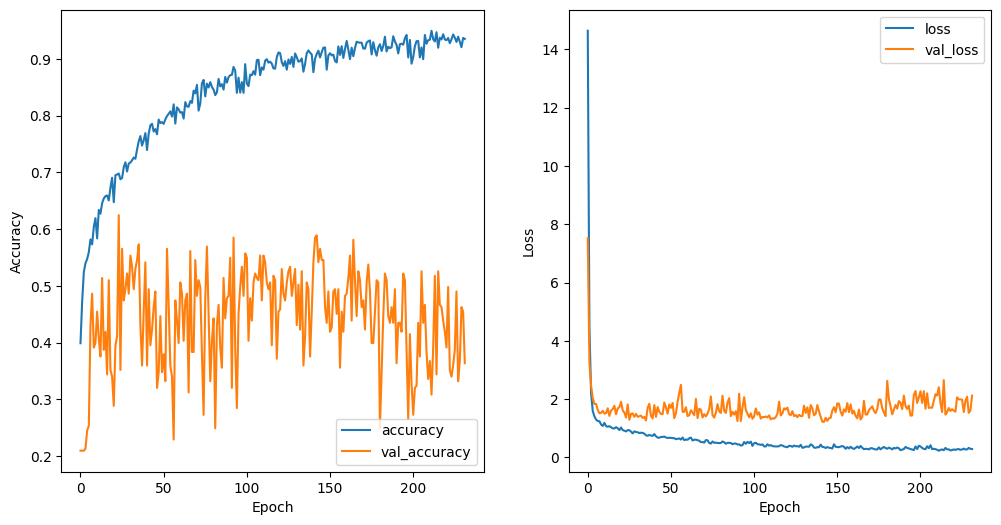

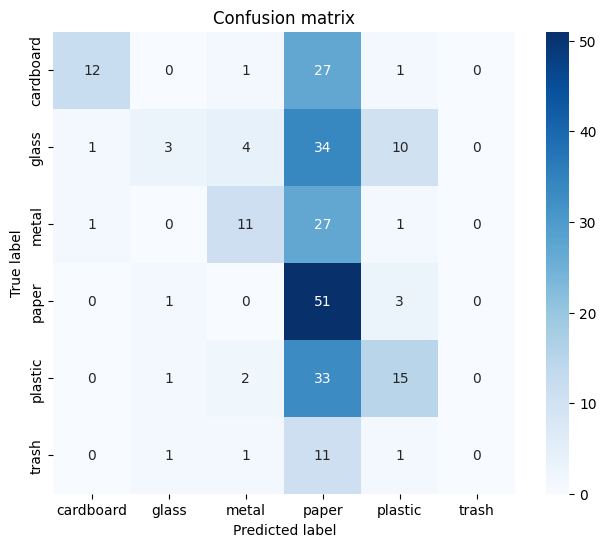

In [31]:
model_cnn8.evaluate()

In [32]:
count = {}
for dir in os.listdir("train/"):
    count[dir] = len(glob.glob(os.path.join( "train/",dir, '*.jpg')))

def weigthed_loss(class_weights):
    
    sorted_keys = sorted(class_weights.keys())
    weight_tensor = tf.constant([class_weights[k] for k in sorted_keys], dtype=tf.float32)
    
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        y_true_class = tf.argmax(y_true, axis=-1)
        loss_per_sample = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        sample_weights = tf.gather(weight_tensor, y_true_class)
        weighted_loss = sample_weights * loss_per_sample
        return tf.reduce_mean(weighted_loss)
    
    return loss

weigthed_loss_func = weigthed_loss(count)

In [33]:
IMG_SIZE = (128,128)
model_cnn9 = MModel("model_cnn9")
model_cnn9.set_model(model_cnn_c(IMG_SIZE, dropout=0.2))
model_cnn9.compile(optimizer='adam', loss=weigthed_loss_func, metrics=['accuracy'])
history = model_cnn9.fit(epochs=300, verbose=1, callbacks=[early_stopping])

(128, 128)
Found 2274 images belonging to 6 classes.
Found 253 images belonging to 6 classes.


/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 183ms/step - accuracy: 0.3902 - loss: 776.2567 - val_accuracy: 0.1621 - val_loss: 869.2886
Epoch 2/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.4978 - loss: 550.3151 - val_accuracy: 0.3755 - val_loss: 729.1106
Epoch 3/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.5513 - loss: 500.3292 - val_accuracy: 0.2332 - val_loss: 720.2885
Epoch 4/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s -127256us/step - accuracy: 0.5585 - loss: 481.6963 - val_accuracy: 0.3557 - val_loss: 758.7450
Epoch 5/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.5869 - loss: 456.9410 - val_accuracy: 0.4348 - val_loss: 718.1467
Epoch 6/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.5877 - loss: 465.8365 - val_accuracy: 0.5731 - val_loss: 489.3726
Epoch 7/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.5939 - loss: 436.5338 - val_accuracy: 0.5573 - val_loss: 502.1858
Epoch 8/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accura

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ -19s -18741413us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1

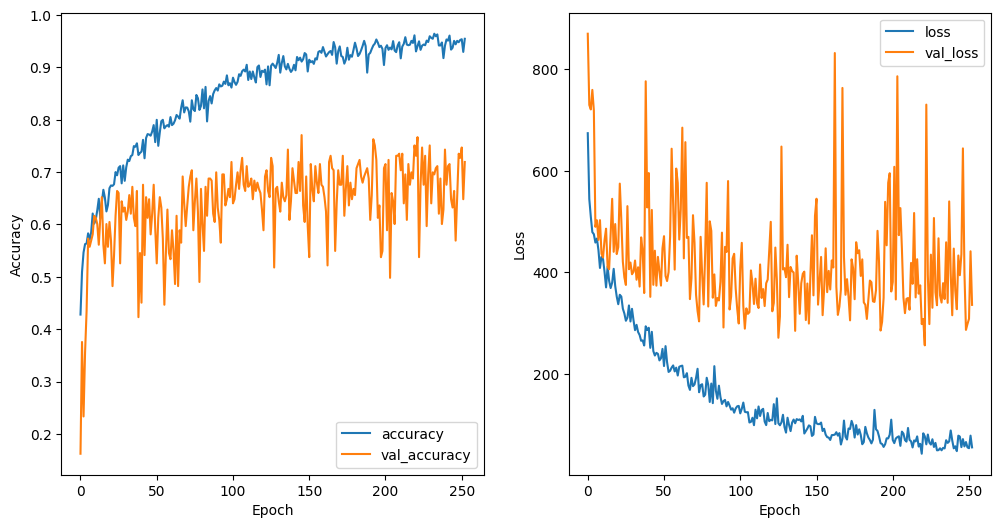

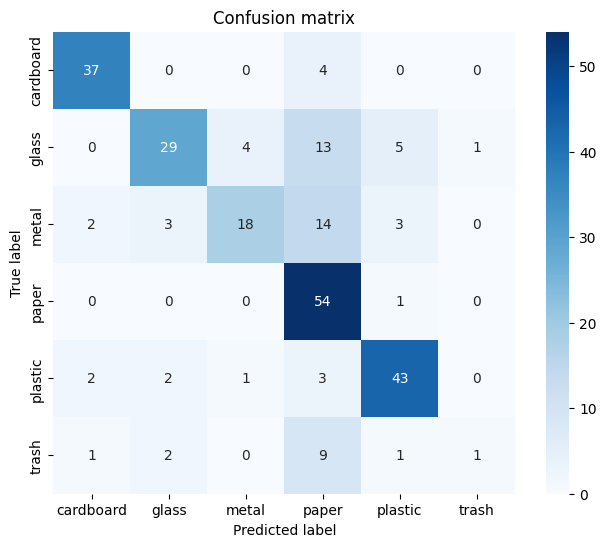

In [34]:
model_cnn9.evaluate()